In [1]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

#### Cargue de datos

| **Nombre de la Variable**  | **Definición**                                                                 |
|----------------------------|-------------------------------------------------------------------------------|
| `year`                     | Año en que se realizó la carrera.                                              |
| `raceId`                   | Identificador único de la carrera.                                             |
| `driverId`                 | Identificador único del piloto.                                                |
| `constructorId`            | Identificador único del constructor (equipo).                                  |
| `grid`                     | Posición de salida del piloto en la parrilla.                                  |
| `final_position`           | Posición final del piloto en la carrera.                                       |
| `driver_points`            | Puntos obtenidos por el piloto en la carrera.                                  |
| `completed_laps`           | Número de vueltas completadas por el piloto en la carrera.                     |
| `race_time_ms`             | Tiempo total del piloto en la carrera en milisegundos.                         |
| `fastestLap`               | Número de la vuelta más rápida del piloto en la carrera.                       |
| `fastest_lap_rank`         | Clasificación de la vuelta más rápida en comparación con otros pilotos.        |
| `fastestLapSpeed`          | Velocidad de la vuelta más rápida en km/h.                                     |
| `qualifying_position`      | Posición del piloto en la clasificación.                                       |
| `driver_standing_points`   | Puntos acumulados por el piloto en la temporada.                               |
| `driver_wins`              | Número de victorias del piloto en la temporada.                                |
| `constructor_points`       | Puntos acumulados por el constructor (equipo) en la temporada.                 |
| `constructor_position`     | Posición del constructor en la temporada.                                      |
| `constructor_wins`         | Número de victorias del constructor en la temporada.                           |
| `fastest_lap_time_ms`      | Tiempo de la vuelta más rápida del piloto en la carrera, en milisegundos.      |
| `lap_position`             | Posición del piloto durante las vueltas en la carrera.                         |


In [9]:
# Conexión a la base de datos MySQL
conn = mysql.connector.connect(
    host='localhost',       # Dirección del servidor MySQL (puede ser localhost si es local)
    user='root',            # Usuario de MySQL (ajusta según tu configuración)
    password='Ringochunin1302',  # Contraseña de MySQL
    database='ergast_f1'    # Nombre de la base de datos
)


# Crear un cursor para ejecutar la consulta
cursor = conn.cursor()

In [12]:
# Ejecutar la consulta para obtener los años disponibles
query = """
SELECT 
    r.raceId, 
    r.driverId, 
    r.constructorId, 
    ra.year,
    ra.date AS race_date,           -- Obtener la fecha completa
    r.positionOrder AS final_position, 
    r.points AS driver_points, 
    r.laps AS completed_laps, 
    r.fastestLap AS fastest_lap,
    r.fastestLapSpeed AS fastest_lap_speed, 
    r.milliseconds AS race_time_ms, 
    q.position AS qualifying_position, 
    ds.points AS driver_standing_points, 
    ds.wins AS driver_wins, 
    cs.points AS constructor_points, 
    cs.wins AS constructor_wins
FROM 
    results r
LEFT JOIN 
    qualifying q ON r.raceId = q.raceId AND r.driverId = q.driverId
LEFT JOIN 
    driverStandings ds ON r.driverId = ds.driverId AND r.raceId = ds.raceId
LEFT JOIN 
    constructorStandings cs ON r.constructorId = cs.constructorId AND r.raceId = cs.raceId
JOIN
    races ra ON r.raceId = ra.raceId
WHERE 
    r.positionOrder IS NOT NULL
    AND ra.year BETWEEN YEAR(CURDATE()) - 20 AND YEAR(CURDATE())  -- Últimos 20 años, incluyendo el año actual
ORDER BY 
    r.raceId, r.driverId;


"""


In [13]:
%%time
cursor.execute(query)

# Obtener los resultados y convertirlos en un DataFrame de pandas
result = cursor.fetchall()

# Obtener los nombres de las columnas
columns = [i[0] for i in cursor.description]

# Convertir los resultados en un DataFrame
df = pd.DataFrame(result, columns=columns)

# Cerrar el cursor y la conexión
cursor.close()
conn.close()

CPU times: total: 62.5 ms
Wall time: 759 ms


In [14]:
df.shape

(8550, 16)

In [19]:
# Usar doble barra invertida en la ruta
df.to_csv("D:\\visualization\\formula1\\data\\processed\\df_train_v3.csv", index=False)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8550 entries, 0 to 8549
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   raceId                  8550 non-null   int64  
 1   driverId                8550 non-null   int64  
 2   constructorId           8550 non-null   int64  
 3   year                    8550 non-null   int64  
 4   race_date               8550 non-null   object 
 5   final_position          8550 non-null   int64  
 6   driver_points           8550 non-null   float64
 7   completed_laps          8550 non-null   int64  
 8   fastest_lap             8159 non-null   float64
 9   fastest_lap_speed       8159 non-null   object 
 10  race_time_ms            4235 non-null   float64
 11  qualifying_position     8526 non-null   float64
 12  driver_standing_points  8488 non-null   float64
 13  driver_wins             8488 non-null   float64
 14  constructor_points      8530 non-null   

### Exploración de datos

In [17]:
df.year.value_counts()

year
2012    480
2016    462
2010    456
2011    456
2023    440
2022    440
2021    440
2019    420
2018    420
2013    418
2014    407
2017    400
2006    396
2024    379
2015    378
2005    376
2007    374
2008    368
2004    360
2020    340
2009    340
Name: count, dtype: int64

In [47]:
# Dado que el nivel de nulos es minimo, se procede a eliminarlos
print((df.isnull().sum()/df.shape[0])*100)

raceId                     0.000000
driverId                   0.000000
constructorId              0.000000
year                       0.000000
final_position             0.000000
driver_points              0.000000
completed_laps             0.000000
fastest_lap                4.479256
fastest_lap_speed          4.479256
race_time_ms              50.924000
qualifying_position        0.293722
driver_standing_points     0.758781
driver_wins                0.758781
constructor_points         0.244768
constructor_wins           0.244768
dtype: float64


In [48]:
df = df.drop(columns=['race_time_ms','raceId','constructorId'])
df = df.dropna()

In [49]:
df.head()

,driverId,year,final_position,driver_points,completed_laps,fastest_lap,fastest_lap_speed,qualifying_position,driver_standing_points,driver_wins,constructor_points,constructor_wins
1,2,2009,10,0.0,58,48.0,216.245,11.0,0.0,0.0,0.0,0.0
2,3,2009,6,3.0,58,48.0,217.668,5.0,3.0,0.0,3.0,0.0
3,4,2009,5,4.0,58,53.0,215.199,12.0,4.0,0.0,4.0,0.0
6,7,2009,8,1.0,58,50.0,212.537,20.0,1.0,0.0,3.0,0.0
7,8,2009,15,0.0,55,35.0,215.744,9.0,0.0,0.0,0.0,0.0


## Análisis univariado

1. **Distribución de `year`**:
   - Los datos están distribuidos uniformemente a lo largo de los años 2014 a 2023, lo cual es esperado ya que la consulta incluye carreras de los últimos 10 años.

2. **Distribución de `driverId`**:
   - La mayoría de los `driverId` están concentrados alrededor de valores altos (más de 800), lo que podría indicar que hay un número considerable de pilotos únicos en la base de datos.

3. **Distribución de `grid`**:
   - La distribución está bastante dispersa en las posiciones de la parrilla de salida. Hay algunas concentraciones en posiciones altas, lo que sugiere que los pilotos suelen comenzar desde posiciones variadas en la parrilla.

4. **Distribución de `final_position`**:
   - La mayoría de las carreras terminan con pilotos en posiciones entre el 1 y el 20, con una caída rápida después del puesto 10.

5. **Distribución de `driver_points`**:
   - **Insight**: La mayoría de los pilotos ganan entre 0 y 10 puntos en las carreras, lo que refleja el sistema de puntuación de la Fórmula 1, donde solo los primeros 10 pilotos obtienen puntos.

6. **Distribución de `completed_laps`**:
   - La mayoría de las carreras tienen un número de vueltas completadas entre 50 y 70. **Insight**: Esto podría reflejar la duración estándar de las carreras en la Fórmula 1.

7. **Distribución de `fastestLap`**:
   - La vuelta más rápida tiende a situarse alrededor de la vuelta 40-60. **Insight**: Los pilotos generalmente marcan sus vueltas más rápidas hacia la mitad o el final de la carrera.

8. **Distribución de `fastest_lap_rank`**:
   - La mayoría de los pilotos no logran marcar la vuelta más rápida, ya que muchos tienen rangos superiores al 10.

9. **Distribución de `fastestLapSpeed`**:
   - La velocidad de la vuelta más rápida varía bastante, pero hay una concentración en valores cercanos a 200-300 km/h.

10. **Distribución de `qualifying_position`**:
    - Las posiciones de clasificación parecen estar distribuidas de manera uniforme entre las posiciones del 1 al 80.

11. **Distribución de `driver_standing_points`**:
    - Los puntos acumulados por los pilotos durante la temporada están bastante distribuidos, aunque hay una tendencia a acumular menos de 20 puntos en una carrera específica.

12. **Distribución de `driver_wins`**:
    - **Insight**: La mayoría de los pilotos tienen pocas victorias en la temporada, con una concentración en 0 victorias. Solo unos pocos logran más de 5 victorias.

13. **Distribución de `constructor_points`**:
    - La distribución tiene una cola larga hacia la derecha, lo que indica que la mayoría de los equipos acumulan pocos puntos, pero algunos pocos equipos tienen una cantidad mucho mayor de puntos.

14. **Distribución de `constructor_position`**:
    - Los constructores tienden a ocupar posiciones desde el 1 hasta el 10, con una caída rápida después del puesto 10.

15. **Distribución de `constructor_wins`**:
    - Similar a la distribución de victorias de pilotos, los constructores suelen tener pocas victorias, con una mayoría de equipos sin victorias.

16. **Distribución de `fastest_lap_time_ms`**:
    - **Insight**: La mayoría de los tiempos de vuelta más rápida están concentrados por debajo de los 2 millones de milisegundos (~33 minutos), lo que parece ser consistente con la duración de una carrera estándar.

17. **Distribución de `lap_position`**:
    - Las posiciones en cada vuelta están distribuidas mayormente en posiciones del 1 al 20, lo que indica que los pilotos se mantienen en esas posiciones durante la carrera.

## Insights Relevantes
- **Los pilotos tienden a acumular pocos puntos en las carreras, lo que refleja el sistema de puntuación de la Fórmula 1**.
- **Las victorias tanto de pilotos como de constructores son raras, con la mayoría concentradas en pocos equipos y pilotos**.
- **La vuelta más rápida generalmente ocurre en las vueltas intermedias o finales de la carrera, lo que podría reflejar cambios de estrategia como paradas en pits o condiciones del neumático**.


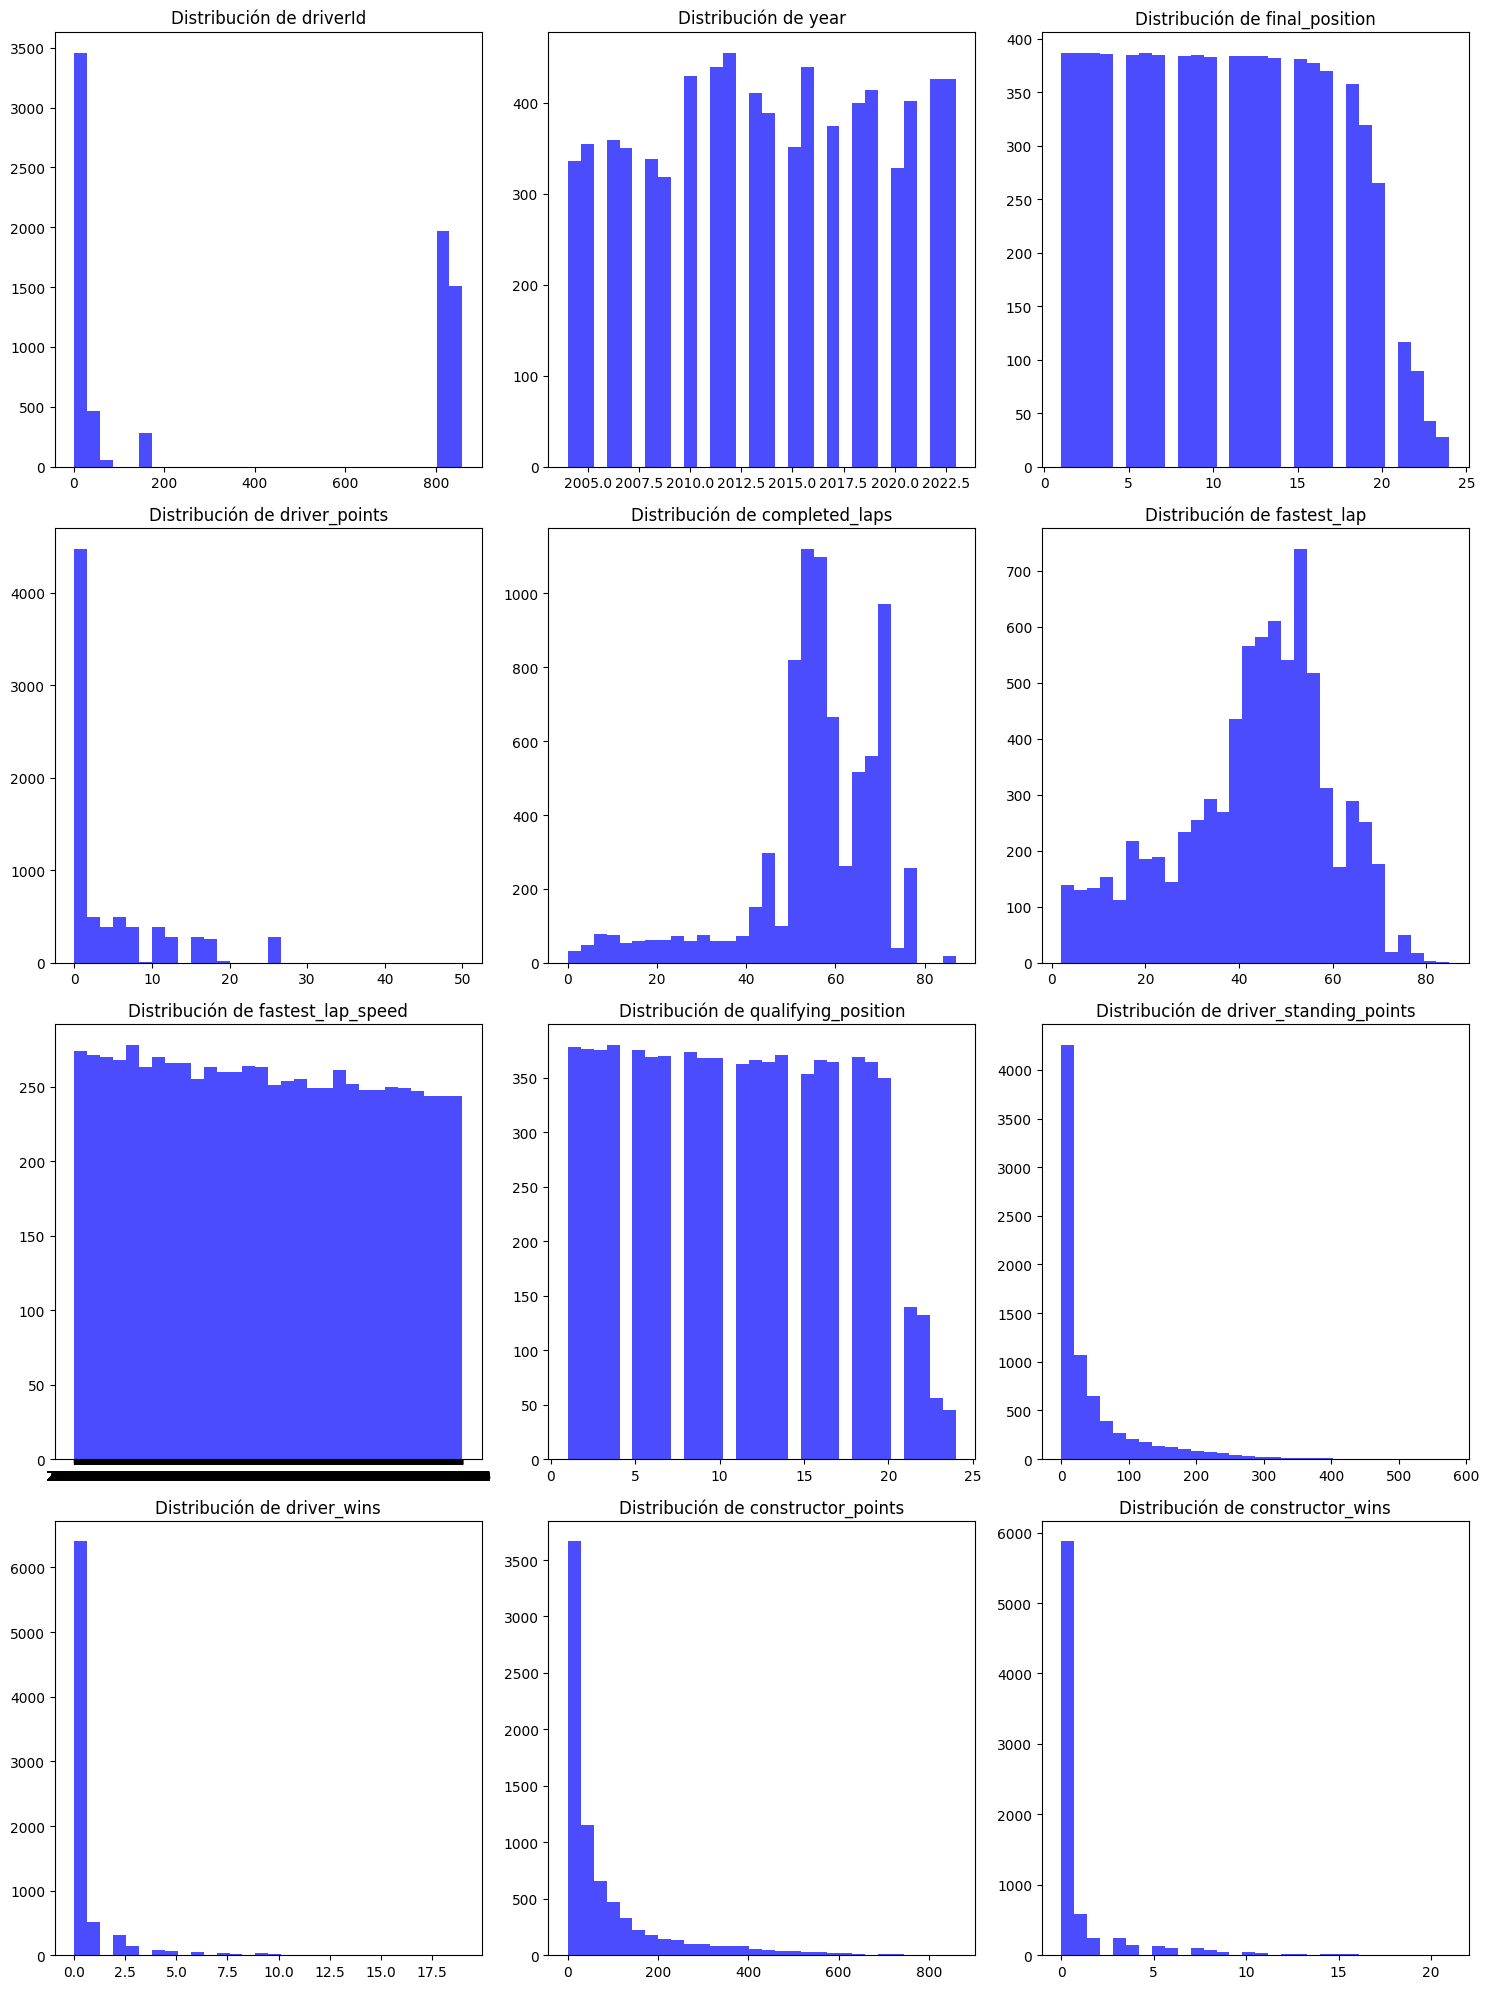

In [50]:
# Definir el número de gráficos por fila
n_graphs_per_row = 3

# Número total de columnas
num_columns = len(df.columns)

# Determinar cuántas filas de gráficos se necesitan
num_rows = (num_columns // n_graphs_per_row) + (num_columns % n_graphs_per_row > 0)

# Crear el gráfico en subplots
fig, axes = plt.subplots(num_rows, n_graphs_per_row, figsize=(15, 5 * num_rows))

# Aplanar el array de ejes en caso de que haya múltiples filas
axes = axes.flatten()

# Generar los histogramas
for i, column in enumerate(df.columns):
    # Generar el histograma de cada columna
    axes[i].hist(df[column].dropna(), bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f'Distribución de {column}')

# Eliminar gráficos vacíos (en caso de que el número de columnas no sea múltiplo de n_graphs_per_row)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para que no se superpongan los gráficos
plt.tight_layout()
plt.show()

## Análisis multivariado

1. **`grid` y `qualifying_position`**:
   - Existe una **alta correlación positiva (0.91)** entre la posición en la parrilla de salida (`grid`) y la posición de clasificación (`qualifying_position`). Esto es esperado, ya que la posición de salida se deriva directamente de la clasificación.

2. **`final_position` y `lap_position`**:
   - La correlación entre la posición final (`final_position`) y la posición durante las vueltas (`lap_position`) es **alta y positiva (0.81)**. Esto indica que los pilotos que mantienen buenas posiciones durante la carrera tienden a terminar en una posición final alta.

3. **`driver_points` y `final_position`**:
   - La correlación es **fuertemente negativa (-0.86)**, lo que significa que cuanto mejor sea la posición final del piloto, más puntos obtiene. Este resultado es lógico, ya que los primeros lugares otorgan más puntos.

4. **`driver_points` y `driver_standing_points`**:
   - Existe una **correlación positiva fuerte (0.66)** entre los puntos obtenidos en una carrera y los puntos acumulados en la temporada, lo que indica que buenos resultados en carreras individuales se reflejan en el total de puntos del piloto en la temporada.

5. **`driver_wins` y `driver_points`**:
   - La correlación entre las victorias de los pilotos y los puntos obtenidos en carreras individuales es de **0.55**, lo que indica que las victorias contribuyen significativamente a la obtención de puntos, pero no es la única variable que influye.

6. **`constructor_points` y `driver_points`**:
   - La correlación entre los puntos del constructor y los puntos del piloto es **alta (0.63)**. Esto muestra que los pilotos en buenos equipos suelen obtener más puntos.

7. **`constructor_points` y `constructor_position`**:
   - Hay una **correlación negativa fuerte (-0.96)**, lo que indica que a medida que el constructor tiene una mejor posición en la temporada, acumula más puntos.

8. **`fastest_lap` y `completed_laps`**:
   - Existe una correlación positiva moderada **(0.62)** entre la vuelta más rápida de un piloto y el número de vueltas completadas. **Insight**: Los pilotos que completan más vueltas tienden a registrar vueltas rápidas en algún momento de la carrera.

9. **`qualifying_position` y `final_position`**:
   - La correlación entre la posición de clasificación y la posición final es **positiva (0.70)**, lo que sugiere que una buena clasificación aumenta las probabilidades de un buen resultado final, pero no lo garantiza.

## Insights Relevantes:
- **Una buena posición en la clasificación tiende a traducirse en una buena posición final, pero no siempre es determinante** (correlación 0.70).
- **La cantidad de puntos obtenidos está altamente relacionada con la posición final del piloto** (correlación -0.86), lo que es consistente con el sistema de puntuación de la Fórmula 1.
- **El éxito del constructor está fuertemente correlacionado con la posición y los puntos acumulados durante la temporada** (correlación -0.96 entre `constructor_position` y `constructor_points`).

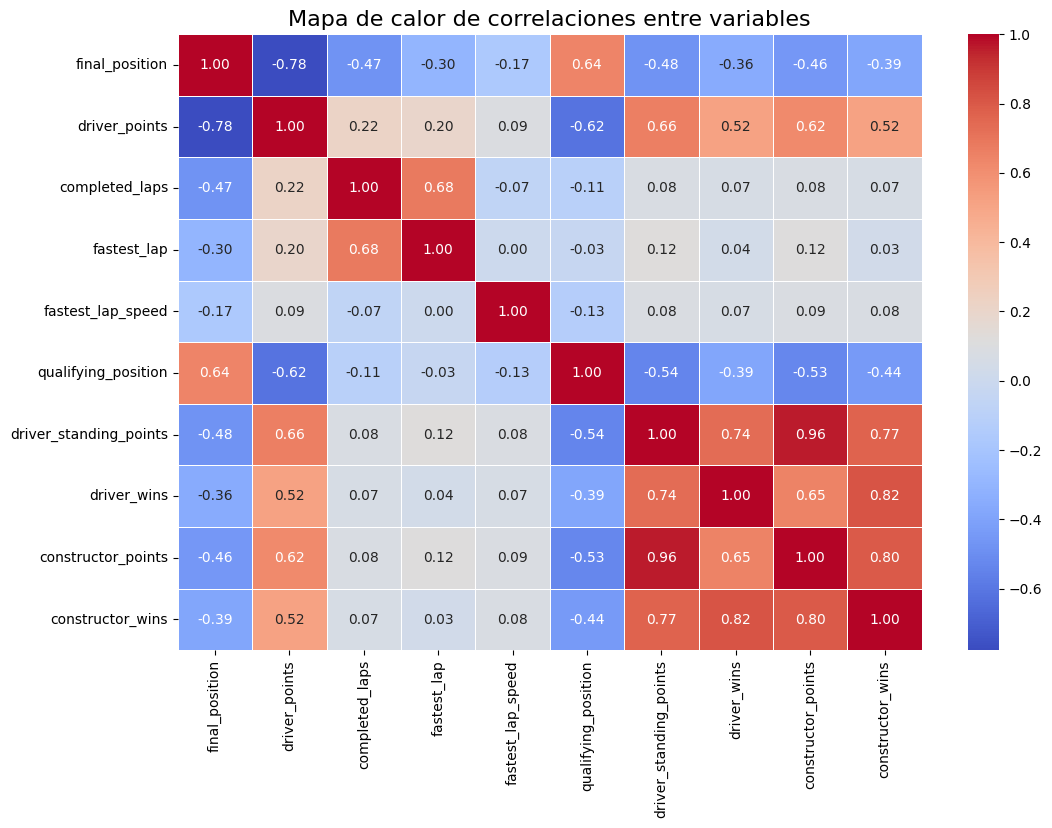

In [51]:
# Eliminar las columnas 'year' y 'driverId' para no incluirlas en el cálculo de correlaciones
df_filtered = df.drop(columns=['year', 'driverId'])

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Generar el mapa de calor usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Título del gráfico
plt.title('Mapa de calor de correlaciones entre variables', fontsize=16)

# Mostrar el gráfico
plt.show()

#### Análisis sobre la eliminación de variables para el modelo

A continuación se analizan las variables que podrían ser eliminadas o ajustadas para evitar redundancia y mejorar el rendimiento del modelo:

#### Variables que podrían eliminarse o ajustarse:

1. **`qualifying_position`**:
   - Tiene una **correlación muy alta con `grid` (0.91)**. Ambas variables reflejan información similar, ya que la posición de salida en la parrilla se deriva de la clasificación.
   - **Recomendación**: Eliminar una de las dos, ya sea `grid` o `qualifying_position`, para evitar redundancia en el modelo.

2. **`lap_position`**:
   - Existe una **alta correlación con la variable `final_position` (0.81)**. Esto sugiere que la posición en las vueltas puede predecir en gran medida la posición final, haciendo que ambas variables aporten información muy similar.
   - **Recomendación**: Eliminar `lap_position` si la variable `final_position` está incluida en el modelo, ya que aporta más valor y la `lap_position` podría ser redundante.

3. **`constructor_position`**:
   - Esta variable tiene una **correlación extremadamente alta con `constructor_points` (-0.96)**. Dado que la posición del constructor depende directamente de los puntos acumulados, resulta redundante incluir ambas.
   - **Recomendación**: Eliminar `constructor_position` y conservar `constructor_points`, que contiene la misma información de forma más precisa.

4. **`driver_standing_points`**:
   - Esta variable tiene una **alta correlación con `driver_points` (0.66)**, lo que sugiere que existe cierta redundancia entre los puntos obtenidos en una carrera y el total acumulado por el piloto en la temporada.
   - **Recomendación**: Eliminar `driver_standing_points` para evitar redundancia, ya que `driver_points` refleja el desempeño en cada carrera.

5. **`fastest_lap` o `fastest_lap_rank`**:
   - Ambas variables tienen correlaciones moderadas entre sí y con otras variables relacionadas con el rendimiento en la carrera. Tener ambas podría no agregar mucho valor adicional.
   - **Recomendación**: Eliminar una de estas dos variables (`fastest_lap` o `fastest_lap_rank`), ya que ambas proporcionan información sobre el desempeño, pero una podría ser suficiente.

### Conclusión:
- **Variables candidatas para eliminar**: 
  - `grid` (o `qualifying_position`)
  - `lap_position`
  - `constructor_position`
  - `driver_standing_points`
  - Una entre `fastest_lap` o `fastest_lap_rank`

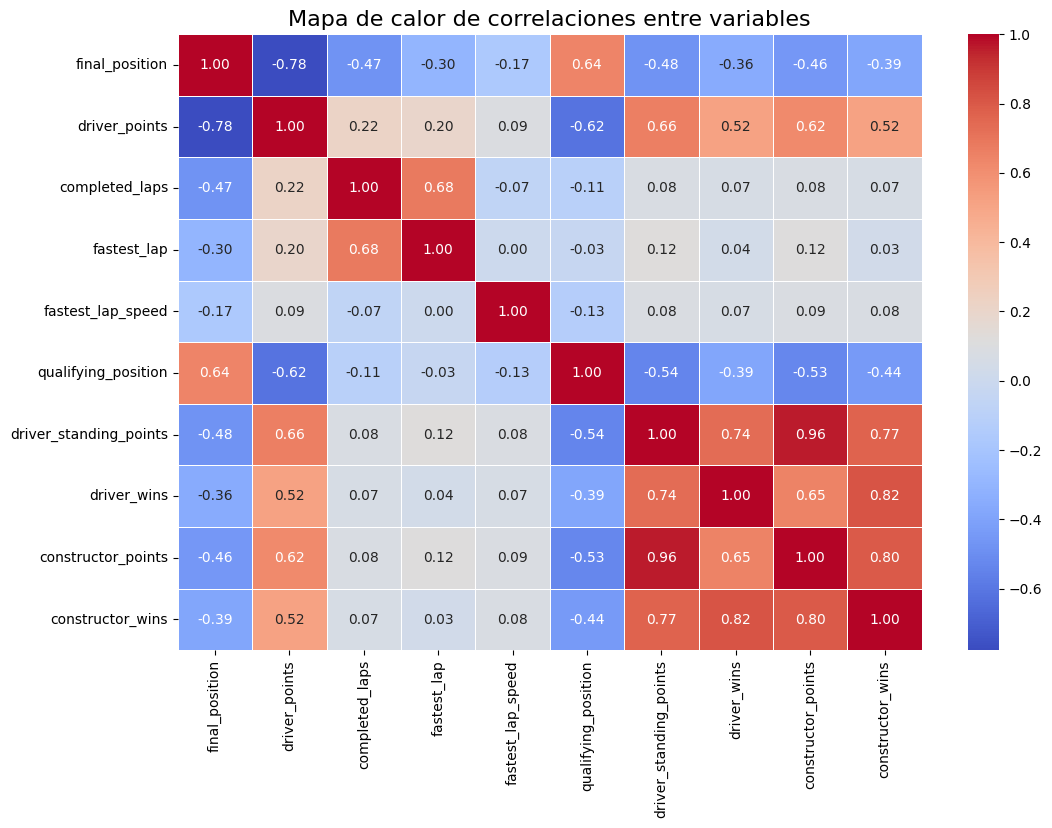

In [52]:
# Eliminar las variables candidatas para eliminar
#columns_to_drop = ['grid', 'lap_position', 'constructor_position', 'driver_standing_points', 'fastest_lap_rank']
df_cleaned = df#.drop(columns=columns_to_drop)

# Eliminar las columnas 'year' y 'driverId' para no incluirlas en el cálculo de correlaciones
df_filtered = df_cleaned.drop(columns=['year', 'driverId'])

# Calcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Generar el mapa de calor usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Título del gráfico
plt.title('Mapa de calor de correlaciones entre variables', fontsize=16)

# Mostrar el gráfico
plt.show()

1. **`final_position` y `driver_points`**:
   - Existe una **correlación fuertemente negativa (-0.86)**, lo que indica que cuanto mejor es la posición final de un piloto, más puntos obtiene, lo cual es consistente con el sistema de puntuación de la Fórmula 1.

2. **`qualifying_position` y `final_position`**:
   - Una correlación positiva alta **(0.70)**, lo que indica que los pilotos que comienzan mejor en la clasificación tienden a obtener mejores posiciones finales, aunque no siempre es determinante.

3. **`driver_wins` y `constructor_wins`**:
   - Hay una **correlación alta (0.83)** entre las victorias de los pilotos y las victorias del constructor. Esto refleja que los equipos exitosos suelen tener pilotos que también ganan carreras.

4. **`constructor_points` y `driver_points`**:
   - Existe una correlación positiva significativa **(0.63)**, lo que indica que los pilotos que obtienen más puntos suelen pertenecer a equipos que también acumulan puntos.

5. **`fastestLap` y `completed_laps`**:
   - Correlación moderada **(0.62)**, lo que sugiere que los pilotos que completan más vueltas tienen más probabilidades de marcar una vuelta rápida en algún punto de la carrera.

6. **`constructor_points` y `constructor_wins`**:
   - **Correlación extremadamente alta (0.84)**, lo que refleja que los equipos con más victorias tienden a acumular la mayor cantidad de puntos, lo cual es consistente con la naturaleza competitiva de la Fórmula 1.

## Insights Relevantes:
- **La relación entre la posición final y los puntos obtenidos por el piloto es muy fuerte**, lo que confirma que la posición en la que termina un piloto es clave para determinar cuántos puntos obtiene.
- **La correlación entre las victorias de los pilotos y los constructores es muy alta**, lo que indica que un equipo exitoso suele tener pilotos ganadores, lo que contribuye al éxito del constructor.
- **Los puntos del constructor están fuertemente correlacionados con las victorias del equipo**, lo que refuerza la importancia de las victorias para lograr una buena clasificación en el campeonato de constructores.

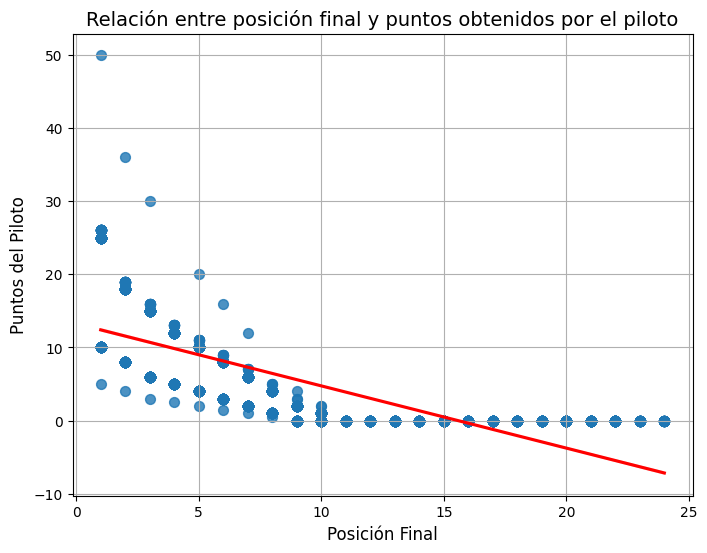

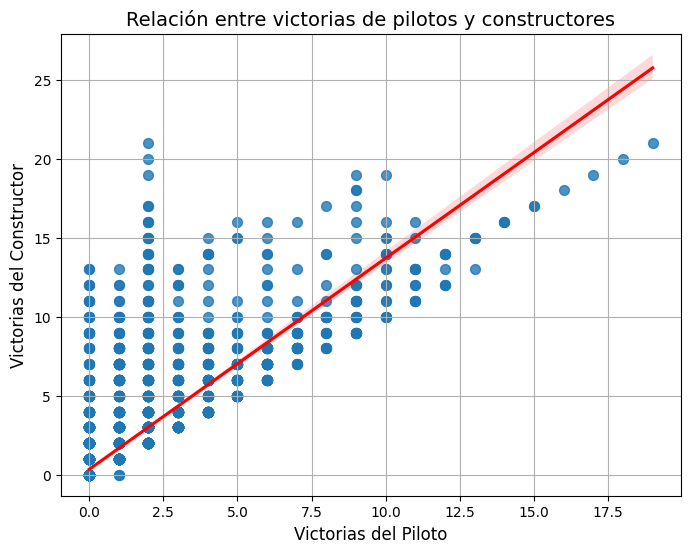

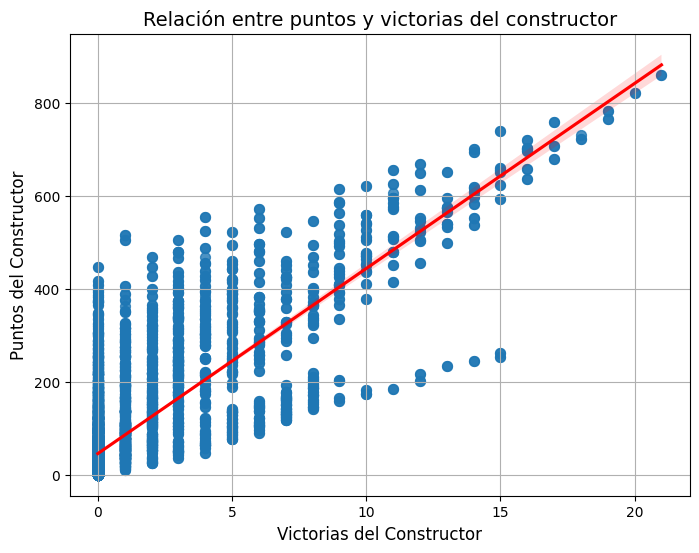

In [53]:
# Gráfica 1: Relación entre posición final y puntos obtenidos por el piloto
plt.figure(figsize=(8, 6))
sns.regplot(x='final_position', y='driver_points', data=df_cleaned, scatter_kws={'s':50}, line_kws={"color": "red"})
plt.title('Relación entre posición final y puntos obtenidos por el piloto', fontsize=14)
plt.xlabel('Posición Final', fontsize=12)
plt.ylabel('Puntos del Piloto', fontsize=12)
plt.grid(True)
plt.show()

# Gráfica 2: Correlación entre victorias de pilotos y victorias de constructores
plt.figure(figsize=(8, 6))
sns.regplot(x='driver_wins', y='constructor_wins', data=df_cleaned, scatter_kws={'s':50}, line_kws={"color": "red"})
plt.title('Relación entre victorias de pilotos y constructores', fontsize=14)
plt.xlabel('Victorias del Piloto', fontsize=12)
plt.ylabel('Victorias del Constructor', fontsize=12)
plt.grid(True)
plt.show()

# Gráfica 3: Relación entre puntos del constructor y victorias del equipo
plt.figure(figsize=(8, 6))
sns.regplot(x='constructor_wins', y='constructor_points', data=df_cleaned, scatter_kws={'s':50}, line_kws={"color": "red"})
plt.title('Relación entre puntos y victorias del constructor', fontsize=14)
plt.xlabel('Victorias del Constructor', fontsize=12)
plt.ylabel('Puntos del Constructor', fontsize=12)
plt.grid(True)
plt.show()


In [54]:
# Usar doble barra invertida en la ruta
df_cleaned.to_csv("D:\\visualization\\formula1\\data\\processed\\df_train_v2.csv", index=False)